In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np

import scipy.optimize as sco

import warnings
warnings.filterwarnings('ignore')

import sklearn.cluster as cl
from sklearn import mixture

data_folder = '../data/'
path = data_folder + 'GEV_SM/swissmetro.dat'

from classes.MNLogit import *
from helpers.data import *
from helpers.algos import *
from helpers.models import *
import copy

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True

import time
import pickle

import hyperopt
from hyperopt.pyll.base import scope
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import seaborn as sns

import numdifftools as nd

sns.set(font_scale=1.5)

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

seed = 1234

In [3]:
model = load_model(path, 'norm')
x = np.zeros(len(model.params))

In [4]:
%%time
res_bfgs = sco.minimize(model.negloglikelihood, x, method='BFGS', tol=1e-8, jac=model.neg_grad)

CPU times: user 2.79 s, sys: 40 ms, total: 2.83 s
Wall time: 2.83 s


In [5]:
res_bfgs.x

array([ 0.786179  ,  0.98264685, -0.65596648, -1.04933718, -0.68768718,
       -1.05748236, -0.8000895 , -1.44306552, -1.45576372, -1.79689044])

In [6]:
res_bfgs.fun

0.7908058095403135

# Percentage of Newton step

In [11]:
nbr = 2
draws = 3

res = {}

batch_sizes = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, len(model.df)]

In [12]:
theo_perc = 1-np.sum(model.df['SENIOR'] == 0)/len(model.df)

In [13]:
%%time
n = len(model.df)
draws_theo = 1000

percs = []

for bs in range(1, 200):
    vals = 0
    for i in range(draws_theo):
        idx = np.random.choice(n, bs, replace=False)
        subdf = model.df.iloc[idx]
        vals = vals + (np.sum(subdf['SENIOR'])>=1)
    proba = vals/draws_theo
    if bs == 100:
        print("100: {}".format(proba))
    percs.append(proba)
    

100: 0.999
CPU times: user 1min 23s, sys: 4 ms, total: 1min 23s
Wall time: 1min 23s


In [14]:
with open('../data/percentage_newton.p', 'wb') as outfile:
    pickle.dump(percs, outfile)

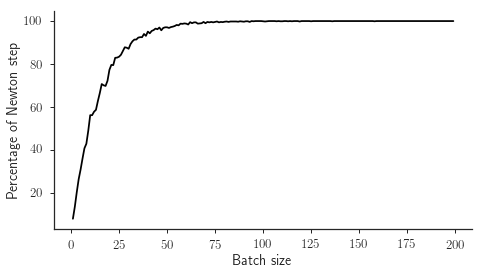

In [7]:
with open('../data/percentage_newton.p', 'rb') as infile:
    percs = pickle.load(infile)
    
plt.figure(figsize=(7.5,4), frameon=False)

sns.set_context("paper")
sns.set(font_scale = 1.3)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(range(1, 200), 100*np.array(percs), 'k')

plt.xlabel('Batch size')
plt.ylabel('Percentage of Newton step')
plt.savefig('../figures/perc_newton.pdf', bbox_inches='tight')

# Dispersion of local minimum

In [12]:
%%time
n = len(model.df)
draws = 1000

dist = {}

for bs in [50, 100, 500, 1000]:
    tmp = []
    for i in range(draws):
        idx = np.random.choice(n, bs, replace=False)
        subdf = model.df.iloc[idx]
        senior = np.sum(subdf['SENIOR'] == 0) == len(subdf)
        f = lambda x: model.negloglikelihood(x, idx)
        g = lambda x: model.neg_grad(x, idx)
        res = sco.minimize(f, x, method='BFGS', tol=1e-3, jac=g)
        d = np.linalg.norm(res.x - res_bfgs.x)
        #print(res.success, senior, d)
        tmp.append(d)
    dist[bs] = np.array(tmp)
    print("{}: avg dist: {}".format(bs, np.mean(tmp)))

50: avg dist: 93.2134290782702
100: avg dist: 4.364059164061623
500: avg dist: 1.4749278815978146
1000: avg dist: 1.0155490526751254
CPU times: user 24min 20s, sys: 248 ms, total: 24min 20s
Wall time: 24min 23s


In [13]:
with open('../data/dist.p', 'wb') as outfile:
    pickle.dump(dist, outfile)

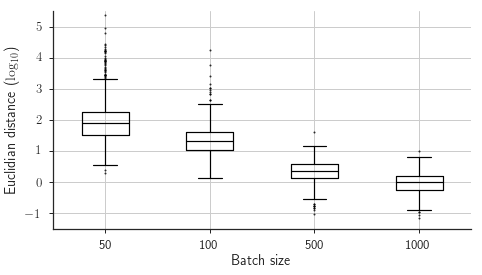

In [8]:
with open('../data/dist.p', 'rb') as infile:
    dist = pickle.load(infile)

plt.figure(figsize=(7.5,4), frameon=False)

sns.set_context("paper")
sns.set(font_scale = 1.3)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

mat = [np.log(dist[50]), np.log(dist[100]), np.log(dist[500]), np.log(dist[1000])]

boxes = ax.boxplot(mat, sym='k.')
plt.ylabel('Euclidian distance ($\log_{10}$)')
plt.xlabel('Batch size')
plt.xticks([1, 2, 3, 4], [50, 100, 500, 1000])
plt.yticks([-1, 0, 1, 2, 3, 4, 5])
plt.grid()
ax.set_ylim([-1.5, 5.5])

for b in boxes:
    for l in boxes[b]:
        l.set_linewidth(1.2)
        l.set_color('k')
        if b == 'fliers':
            l.set_alpha(0.8)
            l.set_marker('o')
            l.set_markersize(2)
            
plt.savefig('../figures/dist.pdf', bbox_inches='tight')